# High-NA vectorial PSF generation

Detailed models are required to generate high-NA point-spread-functions. Due to the large angles, it is crucial to take into account the vectorial nature of the electric field. This approach allows for accurate modeling of polarization and the inclusion of various correction factors.

For more information, please check https://arxiv.org/abs/2502.03170.

In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")

import jax.numpy as jnp
import matplotlib.pyplot as plt

import chromatix.functional as cf

%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [2]:
camera_shape: tuple[int, int] = (256, 256)
pupil_shape: tuple[int, int] = (128, 128)
camera_pixel_pitch: float = (0.005, 0.005)
f: float = 100
NA: float = 1.3
n: float = 1.5
wavelength: float = 0.532
wavelength_ratio: float = 1.0

correction = f * NA / n
dx = 2 * correction / min(pupil_shape)

# Scalar high-NA PSF

In [3]:
field_pup = cf.gaussian_plane_wave(
    pupil_shape,
    dx,
    wavelength,
    wavelength_ratio,
    waist=correction,
    pupil=lambda field: cf.circular_pupil(field, 2 * correction),
)

field = cf.high_na_ff_lens(
    field_pup,
    f,
    n,
    NA,
    camera_shape,
    camera_pixel_pitch,
)

psf_scalar = jnp.abs(field.u.squeeze()) ** 2

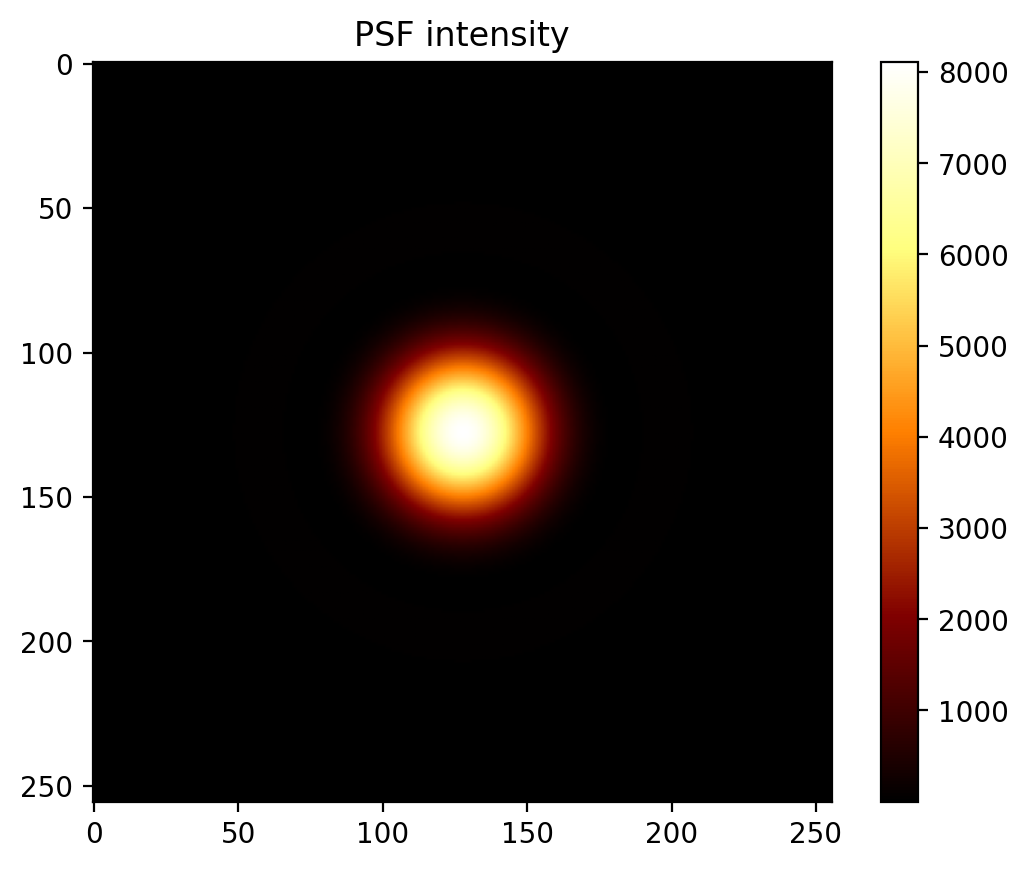

In [4]:
plt.figure()
plt.imshow(psf_scalar.squeeze(), cmap="afmhot")
plt.colorbar()
plt.title("PSF intensity")
# plt.axis("off")
plt.show()

# Vectorial high-NA PSF

In [5]:
field_pup = cf.gaussian_plane_wave(
    pupil_shape,
    dx,
    wavelength,
    wavelength_ratio,
    waist=correction,
    pupil=lambda field: cf.circular_pupil(field, 2 * correction),
    amplitude=jnp.array([0.0, 0.0, 1.0]),
    scalar=False,
)


field = cf.high_na_ff_lens(
    field_pup, f, n, NA, camera_shape, camera_pixel_pitch, gibson_lanni=True
)

psf_vectorial = jnp.abs(field.u.squeeze()) ** 2

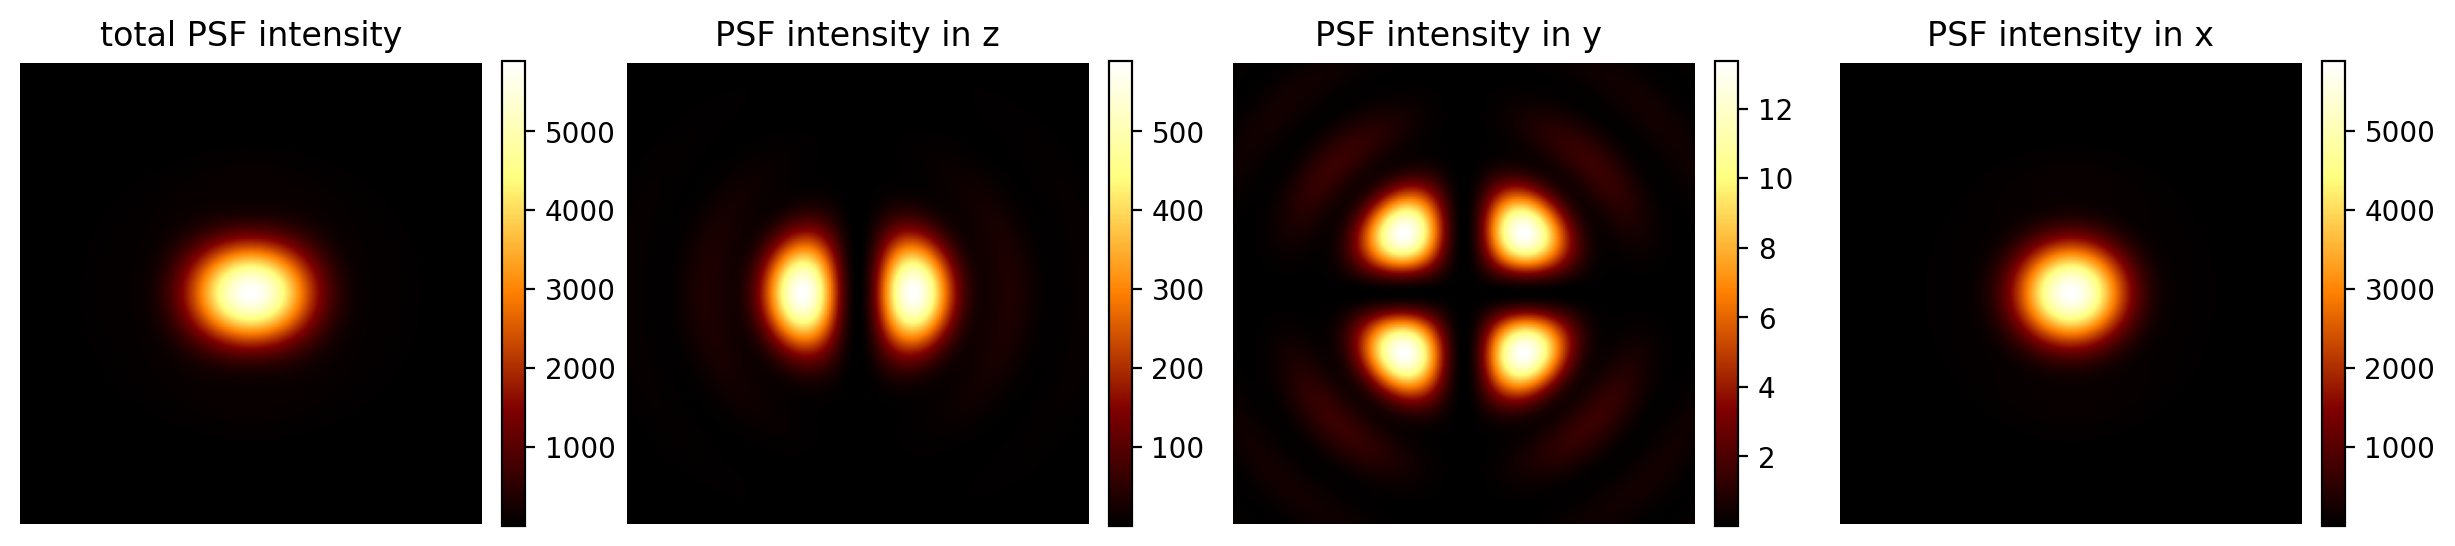

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(jnp.sum(psf_vectorial.squeeze(), axis=-1), cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("total PSF intensity")
plt.axis("off")

plt.subplot(142)
plt.imshow(psf_vectorial.squeeze()[..., 0], cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("PSF intensity in z")
plt.axis("off")

plt.subplot(143)
plt.imshow(psf_vectorial.squeeze()[..., 1], cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("PSF intensity in y ")
plt.axis("off")

plt.subplot(144)
plt.imshow(psf_vectorial.squeeze()[..., 2], cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("PSF intensity in x")
plt.axis("off")

plt.show()